In [39]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from pathlib import Path
from tqdm import tqdm

plt.style.use("ggplot")
plt.style.use("../my.mplstyle")

In [2]:
tcr_data_path = Path("../tcr_data/")

In [3]:
vdjdb = pd.read_csv(
    tcr_data_path/"raw"/"vdjdb"/"vdjdb_20240128.tsv",
    sep="\t"
)

In [5]:
vdjdb

,complex.id,Gene,CDR3,V,J,Species,MHC A,MHC B,MHC class,Epitope,Epitope gene,Epitope species,Reference,Method,Meta,CDR3fix,Score
0,1,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CIVRAPGRADMRF"", ""cdr3_old"": ""CIVRAPG...",2
1,1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSYLPGQGDHYSNQPQHF"", ""cdr3_old"": ""...",2
2,0,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEAGQGFFSNQPQHF"", ""cdr3_old"": ""C...",2
3,2,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVPSGAGSYQLTF"", ""cdr3_old"": ""CAVPSG...",2
4,2,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEPGQGFYSNQPQHF"", ""cdr3_old"": ""C...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92766,30592,TRB,CASSPGQGGDNEQFF,TRBV7-3*01,TRBJ2-1*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQQPFPQPEQPFP,Gluten,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSPGQGGDNEQFF"", ""cdr3_old"": ""CASSP...",0
92767,30593,TRA,CAPQGATNKLIF,TRAV12-2*01,TRAJ32*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQQPFPQPEQPFP,Gluten,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAPQGATNKLIF"", ""cdr3_old"": ""CAPQGATN...",2
92768,30593,TRB,CASSLGAGGQETQYF,TRBV5-1*01,TRBJ2-5*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQQPFPQPEQPFP,Gluten,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSLGAGGQETQYF"", ""cdr3_old"": ""CASSL...",2
92769,30594,TRA,CLVGGSGGYNKLIF,TRAV4*01,TRAJ4*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQQPFPQPEQPFP,Gluten,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CLVGGSGGYNKLIF"", ""cdr3_old"": ""CLVGGS...",0


In [9]:
alphas = vdjdb[(vdjdb["complex.id"] == 0) & (vdjdb["Gene"] == "TRA")][["V", "J", "CDR3", "Epitope"]].drop_duplicates()
betas = vdjdb[(vdjdb["complex.id"] == 0) & (vdjdb["Gene"] == "TRB")][["V", "J", "CDR3", "Epitope"]].drop_duplicates()

In [10]:
def group_paired_chains(df: DataFrame) -> DataFrame:
    df = df[df["complex.id"] != 0]

    reformatted_rows = []

    sc_complex_ids = df["complex.id"].unique()
    for complex_id in tqdm(sc_complex_ids):
        tcr_info = df[df["complex.id"] == complex_id]

        if tcr_info.shape[0] != 2:
            print(tcr_info)
            raise RuntimeError

        tra_info = tcr_info[tcr_info["Gene"] == "TRA"].iloc[0]
        trb_info = tcr_info[tcr_info["Gene"] == "TRB"].iloc[0]

        reformatted_rows.append(
            {
                "TRAV": tra_info["V"],
                "CDR3A": tra_info["CDR3"],
                "TRAJ": tra_info["J"],
                "TRBV": trb_info["V"],
                "CDR3B": trb_info["CDR3"],
                "TRBJ": trb_info["J"],
                "Epitope": tra_info["Epitope"],
            }
        )

    reformatted_df = DataFrame.from_records(reformatted_rows)
    reformatted_df = reformatted_df.drop_duplicates()
    return reformatted_df

alpha_betas = group_paired_chains(vdjdb)

100%|██████████| 30594/30594 [00:20<00:00, 1458.43it/s]


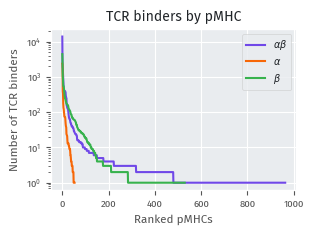

In [44]:
plt.figure(figsize=(8/2.54,6/2.54))
plt.yscale("log")

tcr_nums_alpha = alphas.groupby("Epitope").size().sort_values(ascending=False)
tcr_nums_beta = betas.groupby("Epitope").size().sort_values(ascending=False)
tcr_nums_alphabeta = alpha_betas.groupby("Epitope").size().sort_values(ascending=False)

plt.plot(range(len(tcr_nums_alphabeta)), tcr_nums_alphabeta, label=r"$\alpha\beta$")
plt.plot(range(len(tcr_nums_alpha)), tcr_nums_alpha, label=r"$\alpha$")
plt.plot(range(len(tcr_nums_beta)), tcr_nums_beta, label=r"$\beta$")

plt.xlabel("Ranked pMHCs")
plt.ylabel("Number of TCR binders")
plt.title("TCR binders by pMHC")

plt.legend()
plt.tight_layout()

plt.savefig("tcr_pmhc_data_distribution.svg", bbox_inches="tight")